## Curve di possibilità pluviometrica

L'obiettivo della seguente esercitazione è quello di graficare le curve di possibilità pluviometrica in relazione alle durate orarie della stazione di Venezia e a definiti tempi di ritorno.

La formulazione analitica di tali curve è:

\begin{equation}
h(t_p, T_r) = a(T_r)\cdot t_p^n
\end{equation}

Dove:
- $h(t_p, T_r)$: altezzad i precipitazione $[mm]$
- $t_p$: durata considerata $[h]$
- $Tr$: tempo di ritorno $[anni]$
- $n$: fattore compreso tra $0$ ed $1$

In [1]:
#operazioni preliminari
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

os.getcwd()
data = pd.read_csv('PluviometriaVE.txt')
map(datetime,data['anno'])
data=data.set_index('anno')
import numpy as np

In [2]:
data

,1h,3h,6h,12h,24h
anno,,,,,
2000,36.2,36.2,62.0,73.2,93.2
2001,37.0,52.8,55.0,69.8,78.8
2002,41.8,55.4,58.2,59.0,60.0
2003,25.8,29.8,31.0,41.0,46.8
2004,21.2,28.0,39.0,45.6,61.6
2005,57.2,60.8,61.0,70.0,90.2
2006,36.0,50.4,57.4,93.6,109.2
2007,65.8,92.4,107.4,113.6,127.4
2008,47.2,49.4,59.6,89.8,102.2


Leggo il dataframe con i dati migliori, ottenuto con il Test di Pearson:

In [3]:
best=pd.read_pickle("best_param")
best

,1h,3h,6h,12h,24h
a,31.724736,39.407941,46.548023,51.548581,64.499459
b,14.864016,16.922256,17.541655,21.612033,23.011086


Devo disegnare le curve e intercettarle in modo tale da invertirle per trovare le varie altezze corrispondenti ai quantili che mi interessano.

Per tale operazione è possibile definire una funzione _qtls_ (quantiles), che dato un DataFrame _df_ e i quantili _qu_, restituisce i valori delle ascisse _ppf_ relativi ai quantili, in funzione della curva di Gumbel (definita con _gumbel_r_):

In [4]:
def qtls(df,qu):
    rv1h=gumbel_r(loc=df["a"],scale=df["b"])
    return rv1h.ppf(qu)

Considerando che il quantile è definito come:
\begin{equation}
q = 1 - \frac{1}{T_r}
\end{equation}

Nel caso di un tempo di ritorno di dieci anni ($Tr = 10$) il valore dei quantili sarà pari a: $q=0.9$.

Applico la funzione _qtls_ a ciascuna delle colonne del data frame _best_: tale funzione mi permette trovare le 5 altezze di precipitazione _hi_ relative alle durate orarie $t_p$: 1h, 3h, 6h, 12h e 24h. 

In [5]:
hi=[qtls(best["1h"],0.9),qtls(best["3h"],0.9),qtls(best["6h"],0.9),qtls(best["12h"],0.9),
 qtls(best["24h"],0.9)]
hi

[65.17423296415933,
 77.4892320527388,
 86.02318943757442,
 100.18359456301198,
 116.2828551969069]

Definisco la funzione _h_g_ che definisce le altezze di precipitazioni corrispondenti a un certo tempo di ritorno:

In [6]:
def h_g(bs,col,tr):
    return bs[col]["a"]+bs[col]["b"]*(-math.log(-math.log(1-1/tr)))

Così facendo costruisco le coppie utilizzando la funzione appena definita, mettendo come tempo di ritorno 10 anni:

In [7]:
[h_g(best,"1h",10),h_g(best,"3h",10),h_g(best,"6h",10),h_g(best,"12h",10),h_g(best,"24h",10)]

[65.17423296415933,
 77.4892320527388,
 86.02318943757442,
 100.18359456301198,
 116.2828551969069]

Si calcolano i valori dei quantili relativi a più tempi di ritorno (10, 20 e 100 anni), in quanto le curve devono essere anche visivamente parallele (se non lo sono è probabile che ci siano errori o che i dati siano errati):

In [8]:
Tr=10
q10=1-1/Tr
q20=1-1/20
q100=1-1/100

Definisco il DataFrame _pts_ che fornisce per ciascuna durata oraria il valore corrispondente di precipitazione, assegnato un tempo di ritorno:

In [9]:
pts=DataFrame([[qtls(best["1h"],q10),
           qtls(best["3h"],q10),
           qtls(best["6h"],q10),
           qtls(best["12h"],q10),
           qtls(best["24h"],q10)],
          [qtls(best["1h"],q20),
           qtls(best["3h"],q20),
           qtls(best["6h"],q20),
           qtls(best["12h"],q20),
           qtls(best["24h"],q20)],
          [qtls(best["1h"],q100),
           qtls(best["3h"],q100),
           qtls(best["6h"],q100),
           qtls(best["12h"],q100),
           qtls(best["24h"],q100)]], index=[10,20,100],columns=[1,3,6,12,24]).T
pts

,10,20,100
1,65.174233,75.873767,100.101429
3,77.489232,89.670344,117.252842
6,86.023189,98.650162,127.242252
12,100.183595,115.740540,150.967160
24,116.282855,132.846878,170.353889


Tracciamo innanzitutto un diagramma non logaritmico:


(30.0, 200.0)

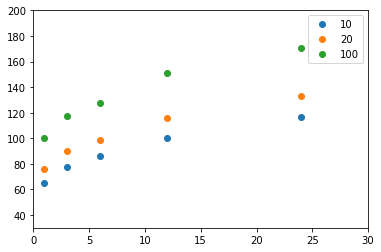

In [10]:
ag=pts.plot(style="o")
plt.xlim([0,30])
plt.ylim([30,200])


(30.0, 200.0)

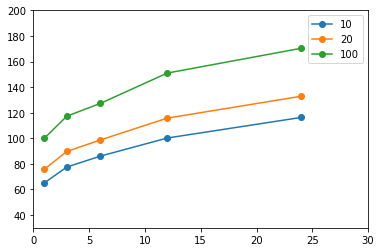

In [11]:
ag=pts.plot(style="-o")
plt.xlim([0,30])
plt.ylim([30,200])

Ora l'obiettivo è quello di disegnare i punti del DataFrame _pts_ su un diagramma bilogaritmico, settando anche gli intervalli di validità:

(50, 200)

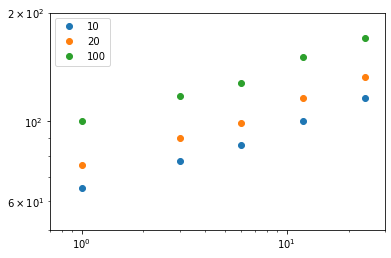

In [12]:
ag=pts.plot(style="o")
#plt.get_xaxis().get_major_formatter().set_scientific(False)
#plt.get_yaxis().get_major_formatter().set_scientific(False)
ag.set_yscale('log')
ag.set_xscale('log')
plt.xlim([0.7,30])
plt.ylim([50,200])

Nel diagramma bilogaritmico, le curve di possibilità pluviometrica sono delle rette.

Per eseguire questa operazione è possibile applicare i metodi già proposti per l'interpolazione delle curve di Gumbel, anche nel caso delle curve di possibilità pluviometrica. 

Oppure grazie alla funzione _polyfit_, si trova una retta a meno di errori di arrotondamento, il cui coefficiente angolare è 1 e l'intercetta praticamente 0.

In [13]:
f=[1,2,3,4]
g=[1,2,3,4]
np.polyfit(f,g,1)
#interpola g rispetto ad f con un polinomio di ordine 1

array([1.00000000e+00, 1.11022302e-15])

Adesso dobbiamo interpolare i vari punti delle altezze di precipitazione (ordinata) appartenenti a _pts_, relative ai diversi tempi di ritorno considerati.

Altezze di precipitazione relative al tempo di ritorno di 10 anni:

In [14]:
pts[10]

1      65.174233
3      77.489232
6      86.023189
12    100.183595
24    116.282855
Name: 10, dtype: float64

La mia ascissa invece corrisponde alla colonna indice del dataframe _pts_: 

In [15]:
pts[10].index

Int64Index([1, 3, 6, 12, 24], dtype='int64')

Uso metodo di interpolazione lineare ma sui logaritmi, trovo un nuovo vettore.
Calcolo con questa funzione il logaritmo sulle ascisse:

Se considero il logaritmo della definizione di curva di possibilità pluviometrica, ottengo una retta con coefficiente angolare _n_:

\begin{equation}
\log h(t_p, T_r) = \log a(T_r) + n\log t_p
\end{equation}


Definisco all'interno della variabile _in10_ i punti relativi al tempo di ritorno di 10 anni con la funzione _polyfit_ (fornendo il valore del logaritmo delle altezze di precipitazione e delle ordinate) per ottenere una retta:

In [16]:
np.log(pts[10])

1     4.177064
3     4.350139
6     4.454617
12    4.607004
24    4.756026
Name: 10, dtype: float64

Calcolo il logaritmo sulle ordinate:

In [17]:
 np.log(pts[10].index)

Float64Index([               0.0, 1.0986122886681098,  1.791759469228055,
              2.4849066497880004, 3.1780538303479458],
             dtype='float64')

In [18]:
in10=np.polyfit(np.log(pts[10].index),np.log(pts[10]),1)
in10[1]=np.exp(in10[1])
in10

array([ 0.1813483 , 63.99107206])

Trovo per un Tr=10:
- coefficiente angolare n: $0.17$ 
- intercetta a: $64.06$
Ripeto le operazioni per gli altri tempi di rintorno (20 e 100 anni):

In [19]:
in20=np.polyfit(np.log(pts[20].index),np.log(pts[20]),1)
in20[1]=np.exp(in20[1])
in20

array([ 0.17621423, 74.44227875])

In [20]:
in100=np.polyfit(np.log(pts[100].index),np.log(pts[100]),1)
in100[1]=np.exp(in100[1])
in100

array([ 0.16847172, 98.11213113])

Posso riassumere questi passaggi con una funzione che, assegnato il Dataframe relativo alle precipitazioni e un tempo di ritorno, restituisce i rispettivi valori di coefficiente angolare n e di intercetta a.


In [21]:
def inna(pt,tr):
    a=np.polyfit(np.log(pt.index),np.log(pt[tr]),1)
    return [a[0], np.exp(a[1])]
in10=inna(pts,10)
in20=inna(pts,20)
in100=inna(pts,100)

in10

[0.18134830294660395, 63.99107206439648]

Con tali informazioni, posso costruirmi un nuovo DataFrame con i dati dei 10 anni di tempo di ritorno, 20 e 100.
Trovo quindi i coefficienti.

In [22]:
fnl=DataFrame([in10,in20,in100],index=[10,20,100],columns=["n","a"])
fnl

,n,a
10,0.181348,63.991072
20,0.176214,74.442279
100,0.168472,98.112131


Voglio generare i grafici delle curve utilizzando questi parametri a ed n; definisco quindi la funzione _h_ di 
possibilità pluviometrica:

In [23]:
def h(tp,a,n):
    return a*tp**n

Dove per durata definisco la variabile _tp_ che abbia 100 punti, i cui estremi devono racchiudere le durate 1h e 24h:

In [24]:
tp=np.linspace(0.7,30,100)
tp[-5:] #mostra gli ultimi 5 punti

array([28.81616162, 29.11212121, 29.40808081, 29.7040404 , 30.        ])

Per disegnare il tutto uso la definizione delle curve di possibilità pluviometrica e poi eseguo i calcoli per le varie durate:

In [25]:
h10=h(tp,fnl["a"][10],fnl["n"][10])
h20=h(tp,fnl["a"][20],fnl["n"][20])
h100=h(tp,fnl["a"][100],fnl["n"][100])

Inserisco questi valori in un DataFrame, che ha come indice i tempi di ritorno e i valori di _tp_ come colonne:

In [26]:
inh=DataFrame([h10,h20,h100],index=["Tr = 10","Tr = 20","Tr = 100"],
              columns=tp).T
inh[-5:]

,Tr = 10,Tr = 20,Tr = 100
0.700000,59.982999,69.907493,92.390243
0.995960,63.944107,74.389189,98.045234
1.291919,67.033474,77.879098,102.438384
1.587879,69.588467,80.761901,106.060764
1.883838,71.779112,83.231221,109.159059
...,...,...,...
28.816162,117.712321,134.594813,172.834372
29.112121,117.930651,134.837382,173.132160
29.408081,118.147171,135.077928,173.427441
29.704040,118.361915,135.316488,173.720261


A questo punto posso disegnare le curve di possibilità pluviometrica:

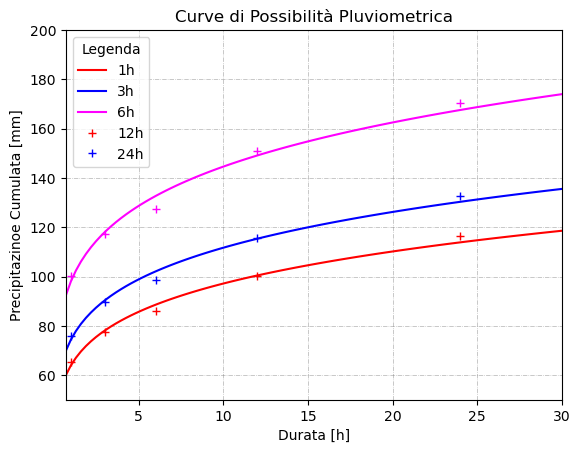

In [27]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('default')
ag=inh.plot(color= ["red","blue", "magenta" ])
ag.plot(pts[10],'+',c="red",label="10h", markersize=6)
ag.plot(pts[20],"+",c="blue",label="20h", markersize = 6)
ag.plot(pts[100],"+",c="magenta", label ="100h", markersize = 6)
#ag.set_yscale('log')
#ag.set_xscale('log')
plt.xlim([0.7,30])
plt.ylim([50,200])
ag.set_title('Curve di Possibilità Pluviometrica')
ag.set_xlabel('Durata [h]')
ag.set_ylabel('Precipitazinoe Cumulata [mm]')
ag.set_aspect('auto')
plt.legend(['1h', '3h', '6h', '12h', '24h'],  title = "Legenda", title_fontsize = 10)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)


Nel grafico bilogaritmico, otterrò le rette relative alle curve di possibilità pluviometrica:

(50, 200)

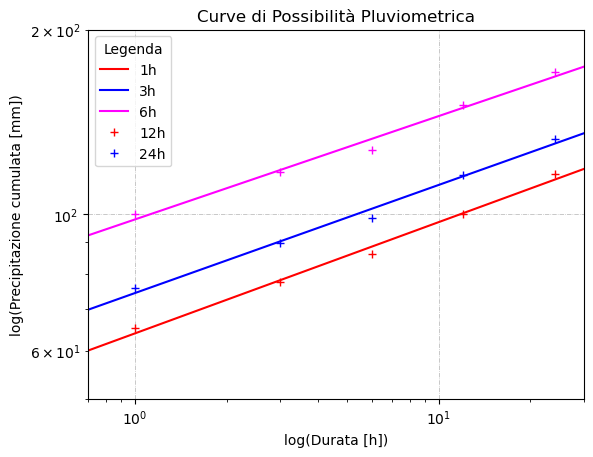

In [28]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('default')
ag=inh.plot(color= ["red","blue", "magenta" ])
ag.set_yscale('log')
ag.set_xscale('log')

ag.plot(pts[10],'+',c="red",label="10h", markersize=6)
ag.plot(pts[20],"+",c="blue",label="20h", markersize = 6)
ag.plot(pts[100],"+",c="magenta", label ="100h", markersize = 6)

ag.set_title('Curve di Possibilità Pluviometrica')
ag.set_xlabel('log(Durata [h])')
ag.set_ylabel('log(Precipitazione cumulata [mm])')
ag.set_aspect('auto')
plt.legend(['1h', '3h', '6h', '12h', '24h'],  title = "Legenda", title_fontsize = 10)

#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)

plt.xlim([0.7,30])
plt.ylim([50,200])


Le curve interpolano abbastanza bene i dati e sono inoltre parallele tra loro: la legge di Possibilità Pluviometrica che abbiamo utilizzato va abbastanza bene per i nostri dati.

1. grafici
2. automatizzare introducendo funzioni
3. come interpolare invece di Gumbel la GEV - per prendere da 28 in su
4. non usate solo le piogge orarie ma anche le precipitazioni sub-orarie (non aggiungerle ma ottenere due serie di curve di possibilità pluviometrica sia per orarie sia per durate brevi) - per prendere 30 o 30L